In [1]:
!pip install grad-cam

Defaulting to user installation because normal site-packages is not writeable


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [26]:
class Bottleneck(nn.Module):
    expansion = 4  # output_channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample 

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1):  
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) 
        return x

In [27]:
labels = ['Effusion']
train_df = pd.read_csv("data/train_effusion.csv")
valid_df = pd.read_csv("data/val_effusion.csv")
test_df = pd.read_csv("data/test_effusion.csv")
train_df.head()

,id,Effusion
0,00010718_010.png,0
1,00011153_000.png,0
2,00007880_000.png,0
3,00011301_000.png,0
4,00029109_000.png,0


In [28]:
class ChestXrayBinaryDataset(Dataset):
    def __init__(self, df, image_dir, label_name, transform=None):
        """
        df: DataFrame chứa thông tin ảnh và nhãn
        image_dir: Thư mục chứa ảnh
        label_name: Tên của nhãn cần phân loại (chuỗi)
        transform: Các phép biến đổi ảnh (nếu có)
        """
        self.df = df
        self.image_dir = image_dir
        self.label_name = label_name
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Đọc ảnh
        image_path = f"{self.image_dir}/{self.df.iloc[idx]['id']}"
        image = Image.open(image_path).convert("RGB")

        # Lấy nhãn dạng nhị phân (0 hoặc 1)
        label = torch.tensor(
            self.df.iloc[idx][self.label_name], dtype=torch.float32
        )

        # Biến đổi ảnh (nếu có)
        if self.transform:
            image = self.transform(image)

        return image, label


In [29]:
import random
class RandomBottomCrop(object):
    def __init__(self, crop_height_ratio=0.5):
        self.crop_height_ratio = crop_height_ratio

    def __call__(self, img):
        w, h = img.size
        crop_h = int(h * self.crop_height_ratio)
        max_start = h - crop_h
        start_y = random.randint(max_start - crop_h//3, max_start)
        return img.crop((0, start_y, w, start_y + crop_h))

In [30]:
transform_train = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),  
    transforms.Resize((320, 320)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [31]:
transform = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = ChestXrayBinaryDataset(train_df, 'data/images',labels[0], transform_train)
valid_dataset = ChestXrayBinaryDataset(valid_df, 'data/images',labels[0], transform)
test_dataset =  ChestXrayBinaryDataset(test_df, 'data/images',labels[0], transform)

In [59]:
def genCam(imagePath):
    # Load model
    model = ResNet50()
    model = torch.load("data/model/model_Effusion (3).pth", map_location='cpu', weights_only=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Grad-CAM layer
    target_layer = model.module.layer4[-1] if isinstance(model, torch.nn.DataParallel) else model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Load and preprocess image
    image = Image.open(imagePath).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
        prob = output.sigmoid().item()

    # Grad-CAM
    targets = [ClassifierOutputTarget(0)]  # Class index 0
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # Remove batch dim

    # Prepare original image
    rgb_img = np.array(image.resize((320, 320)))
    grayscale_cam_resized = cv2.resize(grayscale_cam, (320, 320))

    # Visualization (convert to RGB for display)
    visualization = show_cam_on_image(rgb_img / 255.0, grayscale_cam_resized, use_rgb=True)

    # Plot original + CAM
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"Grad-CAM-Effusion\np: {prob:.3f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

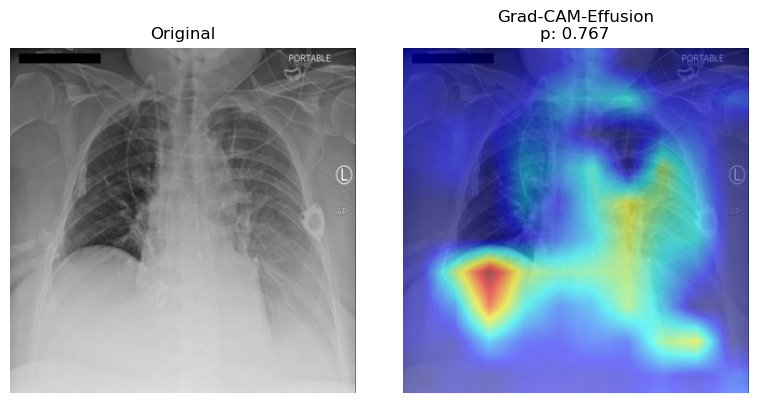

In [60]:
genCam("data/images/00029464_012.png")

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_probs_and_labels(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    probs = []
    labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            probs.extend(out.cpu().numpy().flatten())
            labels.extend(y.cpu().numpy().flatten())
    return np.array(probs), np.array(labels)

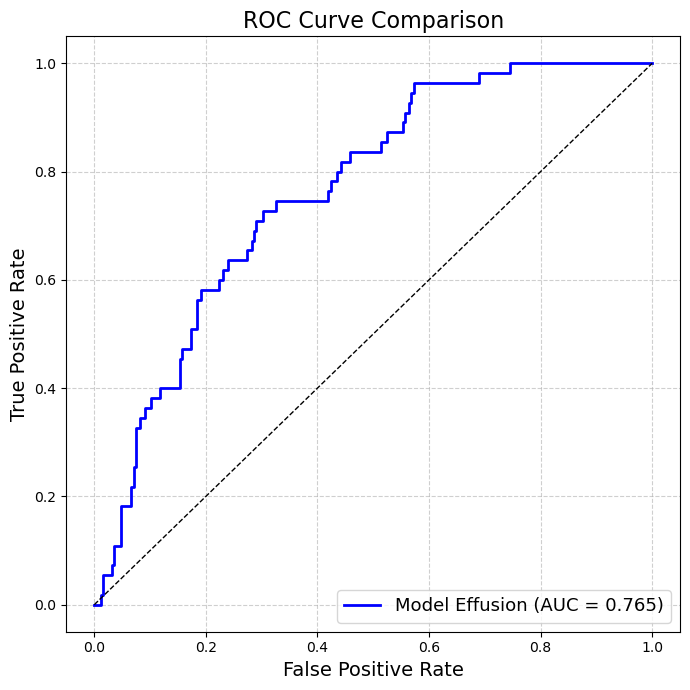

In [56]:
model = ResNet50()
model = torch.load("data/model/model_Effusion_custom_loss (1).pth", map_location='cpu', weights_only=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
probs1, labels1 = get_probs_and_labels(model, test_dataset)
fpr1, tpr1, _ = roc_curve(labels1, probs1)
auc1 = auc(fpr1, tpr1)
plt.figure(figsize=(7,7))
plt.plot(fpr1, tpr1, color='blue', linewidth=2, label=f'Model Effusion (AUC = {auc1:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(fontsize=13, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [2]:
def evaluate_full(model, dataloader):
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
        
            if outputs.shape[1] == 1:  
                probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
                preds = (probs >= 0.5).astype(int)
            else:  
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = probs.argmax(axis=1)
                probs = probs[:, 1]  

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    # Tính metrics
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
evaluate_full(model, test_loader)